In [1]:
import numpy as np
from IPython.core.debugger import set_trace
import re
import difflib
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import time
import random
import pickle
from lxml.html import fromstring
from collections import Counter
from requests.packages.urllib3.util import Retry
from requests.adapters import HTTPAdapter
from requests import Session, exceptions
import sys
import pymongo
from pymongo import MongoClient
from newspaper import Article
import json
from string import digits
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from nltk.stem.porter import *
from collections import Counter 
from nltk.corpus import wordnet # To get words in dictionary with their parts of speech
from nltk.stem import WordNetLemmatizer # lemmatizes word based on it's parts of speech
from nltk.corpus import stopwords 
from textblob import TextBlob
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import cmudict
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from langdetect import detect
from numpy import dot
from numpy.linalg import norm
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
sys.path.append("/Users/rohanramesh/Documents/GitHub/Insight_writers/lib/")
from text_processing import ProcessArticle as pa
import suggestions as s
from scipy.stats import wilcoxon, sem

# Internal validations
I will use a split article approach to validate my writer style recommendations and my content recommendations. I will compare internal (ie within article) as a control, with random and suggested pairings. I will selected a writer, randomly select an article and split this article in half. I will then select a random writer and a suggested writer, grab an article from each of them, split those articles in half and then calculate the cosine similarity of writing style and content for all pairwise permutations of first and second half of articles.

In [2]:
# data load from muckrack
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/Attempt3_mr_scrape.pickle', 'rb') as handle:
    scrapevar = pickle.load(handle)
    
# load writer df
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_df.pickle', 'rb') as handle:
    writer_df = pickle.load(handle)

In [3]:
# Establish connection with database for individual article content
client = MongoClient()
mydb = client["testinsightdb"]

Grab information from postgres database

In [4]:
# establish connection for writer feature db
dbname = 'writer_feature_db'
username = 'rohanramesh' 
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))
con = None
con = psycopg2.connect(database = dbname, user = username)

postgres://rohanramesh@localhost/writer_feature_db
True


In [5]:
# pull from database about writer features
sql_query = """
SELECT AVG("n_words") AS "avg_n_words",
         AVG("neg_sent") AS "avg_neg_sent",
         AVG("neu_sent") AS "avg_neu_sent",
         AVG("pos_sent") AS "avg_pos_sent",
         AVG("neg_sent_var") AS "avg_neg_sent_var",
         AVG("neu_sent_var") AS "avg_neu_sent_var",
         AVG("pos_sent_var") AS "avg_pos_sent_var",
        AVG("n_sentences") AS "avg_n_sentences",
        AVG("n_wordspersentence") AS "avg_n_wordspersentence",
        AVG("n_wordspersent_variability") AS "avg_n_wordspersent_variability",
        AVG("wordlength") AS "avg_wordlength",
        AVG("wordlength_var") AS "avg_wordlength_var",
        AVG("wordlength_skew") AS "avg_wordlength_skew",
        "author_list"
FROM writer_feature
WHERE "n_words" > 100
GROUP BY "author_list"
HAVING COUNT(*) > 25 
ORDER BY AVG("n_words") DESC
"""
writer_feature_subsection = pd.read_sql_query(sql_query,con)
writer_feature_subsection.head(10)
writer_feature_subsection.replace([np.inf, -np.inf], np.nan)
writer_feature_subsection = writer_feature_subsection.dropna(axis=0, how='any')
norm_writer_feature_subsection = s.normalize_df(writer_feature_subsection)

Look at how dividing article in half vs grabbing random article affects classification based on writer style or content

In [5]:
# load word2vec model keyedvectors to make content based suggestions
kv = gensim.models.KeyedVectors.load(
    "/Users/rohanramesh/Documents/Insight/data_bball_writers/word2vec_model_kv.kv", mmap='r')
# load word2vec df for comparisons - this is a collection of the word2vec vectors for all articles in db
w2v_df = pd.read_pickle('/Users/rohanramesh/Documents/Insight/data_bball_writers/word2vec_trained.pickle')

In [116]:
# Functions for calculating cosine similarity between two articles for both writing style and content
def compare_content_two_articles(keyedvectors, w2v_df, article1, article2):
    """
    calculate the cos sim between two articles by running both articles through w2v model
    and comparing vectors. The articles can be completely unprocessed
    :param keyedvectors: vectors from trained w2v model
    :param w2v_df: dataframe with all vectors from previous articles
    :param article1: first article (unprocessed text)
    :param article2: second article (unprocessed text)
    :return: sim: cosine similarity between two articles
    """
    lem_art1 = s.lemstr(gensim.utils.simple_preprocess(article1))
    lem_art2 = s.lemstr(gensim.utils.simple_preprocess(article2))
    article_vector1 = s.get_vector_from_w2v_model(keyedvectors, lem_art1)
    article_vector2 = s.get_vector_from_w2v_model(keyedvectors, lem_art2)
    sim = cos_sim(article_vector1, article_vector2)
    return sim

def compare_style_two_articles(article1, article2, writer_feature_subsection):
    """
    calculate the cos sim between two articles for writing style. 
    The articles can be completely unprocessed
    :param article1: first article (unprocessed text)
    :param article2: second article (unprocessed text)
    :param writer_feature_subsection: pandas df that has the average writing style for all writers in db
    :return: sim: cosine similarity between two articles
    :return: norm_vec1: the normalized vector for article1
    :return: norm_vec2: normalized vector for article2
    """
    curr1 = pa(article1)
    vec1 = curr1.build_feature_vector_for_article()
    norm_vec1 = s.normalize_vec(vec1, writer_feature_subsection.mean().tolist(),
                             writer_feature_subsection.std().tolist())
    curr2 = pa(article2)
    vec2 = curr2.build_feature_vector_for_article()
    norm_vec2 = s.normalize_vec(vec2, writer_feature_subsection.mean().tolist(),
                             writer_feature_subsection.std().tolist())
    sim = s.cos_sim(norm_vec1, norm_vec2)
    return sim, norm_vec1, norm_vec2

This is the code chunk that will iterate through all writers and for 50x grab a suggested and a random writer's articles and do the writer style and content based comparisons after splitting all articles in half. Note that for now I am not worrying about splitting words in half when I split the article in half because I was struggling to reverse my word tokenization if I split on word number

In [233]:
# Iterate over all relevant authors and do the bootstrap comparison x times
# TODO: turn the output of random and suggested writer comparisons into fn bc right now way too repetitive
authorlist = norm_writer_feature_subsection['author_list'].tolist()
n_articles_test = 50
n_articles_comp = 50
n_boot_comp = 50
n_terms_in_vec = 13
similarity_within_author = {}
baseline_across_author = {}
similarity_within_sugg = {}
# iterate over authors
for ii in range(0,np.shape(writer_df)[0]):
    curr_name = writer_df['website_name'][ii]
    curr_name_full = writer_df['Idea Text'][ii]
    print(curr_name)
    # only continue if there are actual suggestions in out dataset
    sugg = s.give_author_suggestion_from_author(writer_feature_subsection, curr_name)
    if not isinstance(sugg, pd.DataFrame):
        continue
    t = time.time()
    currcol = mydb[curr_name]
    y = currcol.find({"name": curr_name})
    totalarticlen = y.count()
    # require the author to have at least 25 articles otherwise things get funky with sampling 50 times
    if totalarticlen < 25:
        continue
    # preallocate for each comp
    similarity_within_author[curr_name] = {}
    baseline_across_author[curr_name] = {}
    similarity_within_sugg[curr_name] = {}
    content_sim = []
    style_sim = []
    # for pooling across first and second half
    first_pool = np.empty((n_boot_comp, n_terms_in_vec)) * np.nan
    second_pool = np.empty((n_boot_comp, n_terms_in_vec)) * np.nan
    # WITHIN AUTHOR AND WITHIN ARTICLE COMPARISON
    for jj in range(0, n_boot_comp):
        # randomly grab an article from an author
        curr_idx = random.sample(range(0,totalarticlen),1)
        curr_article = y[curr_idx[0]]['article']
        tokens = word_tokenize(curr_article)
        # only continue if more than 250 words in article bc the sentiment variability scores aren't accurate with 
        # fewer than 4 sentences
        if len(tokens) < 250: # if fewer than 250 words don't bother
            continue
        # split article in half - not worrying right now about cutting words in half
        first_half = curr_article[0:int(np.floor(len(curr_article)/2))]
        second_half = curr_article[int(np.floor(len(curr_article)/2)):]
        # calculate similarity between first and second half for both content and style
        content_sim.append(compare_content_two_articles(kv, w2v_df, first_half, second_half))
        a, b, c = compare_style_two_articles(first_half, second_half, writer_feature_subsection)
        style_sim.append(a)
        # now for saving vec
        first_pool[jj,:] = b
        second_pool[jj,:] = c
    similarity_within_author[curr_name]['content'] = content_sim
    similarity_within_author[curr_name]['style'] = style_sim  
    similarity_within_author[curr_name]['style_avg'] = s.cos_sim(
        np.nanmean(first_pool, axis=0), np.nanmean(second_pool, axis=0))    
    # now for baseline testing - COMPARE WITH RANDOM WRITER
    baseline_style = []
    baseline_content = []
    baseline_style_avg = []
    # pool across baseline first and second halves
    first_poolb = np.empty((n_boot_comp, n_terms_in_vec)) * np.nan
    second_poolb = np.empty((n_boot_comp, n_terms_in_vec)) * np.nan
    # iterate over all randomly selected pairings
    for j in range(0,n_boot_comp):
        # randomly select a writer, TODO: make this not a suggested writer
        new_author = random.sample(writer_df['website_name'].tolist(), 1)[0]
        # have to establish new connection to the mongo db for this writer
        currcol2 = mydb[new_author]
        y2 = currcol2.find({"name": new_author}) # this is collection for that writer
        totalarticlen = y2.count()
        if totalarticlen == 0: # if no articles then continue
            continue
        # randomly grab an article from this writer
        curr_idx = random.sample(range(0,totalarticlen),1)
        curr_article2 = y2[curr_idx[0]]['article']
        tokens = word_tokenize(curr_article2)
        if len(tokens) < 250: # if fewer than 250 words don't bother
            continue
        # split article control in half - not worrying right now about cutting words in half
        first_half_control = curr_article2[0:int(np.floor(len(curr_article2)/2))]
        second_half_control = curr_article2[int(np.floor(len(curr_article2)/2)):]
        # now do comps for first and second half - with first or second half from original writer
        # comparisons are for both content and style
        baseline_content.append(compare_content_two_articles(kv, w2v_df, first_half, second_half_control))
        a, b, c2 = compare_style_two_articles(first_half, second_half_control, writer_feature_subsection)
        baseline_style.append(a)
        baseline_content.append(compare_content_two_articles(kv, w2v_df, second_half, first_half_control))
        a, b, c1 = compare_style_two_articles(second_half, first_half_control, writer_feature_subsection)
        baseline_style.append(a)
        # for avg style
        first_poolb[j,:] = c1
        second_poolb[j,:] = c2
    # append information for baseline random comparrison
    baseline_across_author[curr_name]['content'] = baseline_content
    baseline_across_author[curr_name]['style'] = baseline_style 
    baseline_across_author[curr_name]['style_avg'] = s.cos_sim(
                            np.nanmean(first_pool, axis=0), np.nanmean(second_poolb, axis=0))
    # now do same thing but for suggested artists
    author_sugg = sugg['authors'].tolist()[0:4] # these are suggested authors
    suggestedmatch_style = []
    suggestedmatch_style_avg = []
    # for pooled
    first_pools = np.empty((n_boot_comp, n_terms_in_vec)) * np.nan
    second_pools = np.empty((n_boot_comp, n_terms_in_vec)) * np.nan
    for j in range(0,n_boot_comp):
        # randomly grab a suggested author and access his collection on mongo
        new_author = random.sample(author_sugg, 1)[0]
        currcol2 = mydb[new_author]
        # these are suggested articles
        y2 = currcol2.find({"name": new_author})
        totalarticlen = y2.count()
        if totalarticlen == 0: # if no suggested articles continue
            continue
        # randomly sample selected article
        curr_idx = random.sample(range(0,totalarticlen),1)
        curr_article2 = y2[curr_idx[0]]['article']
        tokens = word_tokenize(curr_article2)
        if len(tokens) < 250: # if fewer than 250 words don't bother
            continue
        # split article control in half - not worrying right now about cutting words in half
        first_half_sugg = curr_article2[0:int(np.floor(len(curr_article2)/2))]
        second_half_sugg = curr_article2[int(np.floor(len(curr_article2)/2)):]
        # now do comps for first and second half for both content and style
        a, b, c2 = compare_style_two_articles(first_half, second_half_sugg, writer_feature_subsection)
        suggestedmatch_style.append(a)
        a, b, c1 = compare_style_two_articles(second_half, first_half_sugg, writer_feature_subsection)
        suggestedmatch_style.append(a)
        # for avg
        first_pools[j,:] = c1
        second_pools[j,:] = c2
    similarity_within_sugg[curr_name]['style'] = suggestedmatch_style 
    similarity_within_sugg[curr_name]['style_avg'] = s.cos_sim(
                            np.nanmean(first_pool, axis=0), np.nanmean(second_pools, axis=0))
    # suggestions based on content of article from articles in db
    a = s.lemstr(gensim.utils.simple_preprocess(curr_article))
    b = s.recommend_article_content(kv, w2v_df, lem_text=a)
    c = b['url'].tolist()[0:5] 
    suggestedmatch_content = []
    for i in c:
        m, n = s.grab_article(i)
        suggestedmatch_content.append(compare_content_two_articles(kv, w2v_df, curr_article, m.text))
    similarity_within_sugg[curr_name]['content'] = suggestedmatch_content



zachlowe_nba


/anaconda3/envs/insight_new/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
/anaconda3/envs/insight_new/lib/python3.6/site-packages/ipykernel_launcher.py:62: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
/anaconda3/envs/insight_new/lib/python3.6/site-packages/ipykernel_launcher.py:98: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.


adrian-wojnarowski
lee-jenkins
howardbeck
marc-stein
ethan-sherwood-strauss
jason-concepcion
kevin-arnovitz
tom-haberstroh
nate-duncan
zach-harper
brian-windhorst
sam_amick
david-aldridge
ramona-shelburne
jpdabrams
kevin-pelton
marc-j-spears
matt-moore
shams-charania
kevin-p-oconnor
chris-haynes
dave-mcmenamin
shea-serrano
ian-begley
rachel-nichols
ben-golliver
mike-prada
robmahoney
tim-macmahon
chris-herring
billsimmons
jonathan-tjarks
amin-elhassen
bobby-marks
danny-leroux
chris-mannix
dan-devine
michael-pina
thompsonscribe
ben-golliver
ben-falk
ian-levy
tim-bontemps
henry-abbott
scott-rafferty
ja-dubin
michael-lee
alex-kennedy
derek-bodner


/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


tom-ziller
chris-ballard
josh-eberley
adi-joseph
adam-mares
sam-vecenie
meet-katie-nolan
andrew-sharp
david-thorpe
royce-webb
ericpincus
nick-sciria
paul-flannery
You must `download()` an article first!


ArticleException: 

In [7]:
# Pool across all writers to get a sense for what this looks like for writers as a population
tmpauthorlist = similarity_within_author.keys()
style_sim_within = []
style_sim_across = []
style_sim_sugg = []
content_sim_within = []
content_sim_across = []
content_sim_sugg = []
for ii in similarity_within_author:
    try:
        content_sim_across.append(np.nanmedian(baseline_across_author[ii]['content']))
        content_sim_within.append(np.nanmedian(similarity_within_author[ii]['content']))
        content_sim_sugg.append(np.nanmedian(similarity_within_sugg[ii]['content']))
        style_sim_across.append(np.nanmedian(baseline_across_author[ii]['style_avg']))
        style_sim_within.append(np.nanmedian(similarity_within_author[ii]['style_avg']))
        style_sim_sugg.append(np.nanmedian(similarity_within_sugg[ii]['style_avg']))
        # also look at actual value
#         r = s.give_author_suggestion_from_author(writer_feature_subsection, ii)
    except:
        print(ii)

paul-flannery


/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [235]:
# These are the values across all writers
print(np.nanmean(content_sim_across))
print(np.nanmean(content_sim_within))
print(np.nanmean(content_sim_sugg))
print(np.nanmean(style_sim_across))
print(np.nanmean(style_sim_within))
print(np.nanmean(style_sim_sugg))

0.6529324405048034
0.9056892022655406
0.8879799181090291
0.37714886278881365
0.7668313101314218
0.6280584054023554


Save or load variables for figure making

In [6]:
# save these variables
# validation_variables = [similarity_within_author, baseline_across_author, similarity_within_sugg]
# with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/validation_variables.pickle', 'wb') as handle:
#     pickle.dump(validation_variables, handle, protocol=pickle.HIGHEST_PROTOCOL)

# for load
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/validation_variables.pickle', 'rb') as handle:
    validation_variables = pickle.load(handle)
similarity_within_author = validation_variables[0]
baseline_across_author = validation_variables[1]
similarity_within_sugg = validation_variables[2]

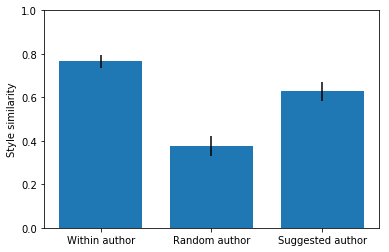

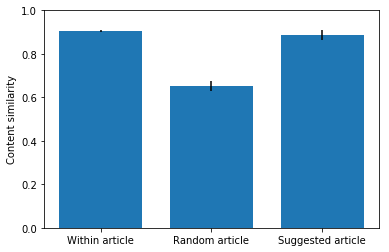

In [257]:
# for style bar plot
plt.bar(range(0,3),[np.nanmean(style_sim_within), 
                    np.nanmean(style_sim_across), 
                   np.nanmean(style_sim_sugg)], 0.75, 
        yerr=[sem(style_sim_within), sem(style_sim_across), sem(style_sim_sugg)], 
        tick_label= ['Within author', 'Random author', 'Suggested author'])
plt.ylabel('Style similarity')
plt.ylim([0, 1])
plt.savefig('/Users/rohanramesh/Documents/Insight/Presentation_material/Figures/Style_similarity.eps', format='eps', dpi=1000)
plt.show()
# for content bar plot
plt.bar(range(0,3),[np.nanmean(content_sim_within), 
                    np.nanmean(content_sim_across), 
                   np.nanmean(content_sim_sugg)], 0.75, 
        yerr=[sem(content_sim_within, nan_policy='omit'),
              sem(content_sim_across, nan_policy='omit'), sem(content_sim_sugg, nan_policy='omit')], 
        tick_label= ['Within article', 'Random article', 'Suggested article'])
plt.ylabel('Content similarity')
plt.ylim([0, 1])
plt.savefig('/Users/rohanramesh/Documents/Insight/Presentation_material/Figures/Content_similarity.eps', format='eps', dpi=1000)
plt.show()
